<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9143HPML/blob/main/Lab/Lab3/Lab3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Batch normalization and Dropout are used as effective regularization techniques. However, it is not clear which one should be preferred and whether their benefits add up when used in conjunction. In this problem, we will compare batch normalization, dropout, and their conjunction using MNIST and LeNet-5 (see e.g., http://yann.lecun.com/exdb/lenet/). LeNet-5 is one of the earliest convolutional neural networks developed for image classification and its implementation in all major frameworks is available.

1. Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need to refer to two papers mentioned below to answer this question. (4)
2. Batch normalization is traditionally used in hidden layers, for the input layer standard normalization is used. In standard normalization, the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer? (4)
3. Next instead of standard normalization use batch normalization for the input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for the input layer improve performance? (4)
4. Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3. (4)
5. Now train the network using both batch normalization and dropout. How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone? (4)

*reference:*

* N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, R.Salakhutdinov . Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Available at at https://www.cs.toronto.edu/ rsalakhu/papers/srivastava14a.pdf.
* S. Ioffe, C. Szegedy. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Available at https://arxiv.org/abs/1502.03167.

![image-17](https://user-images.githubusercontent.com/68700549/159705208-dc706e02-6d90-4cea-9304-c3e62e92bc55.png)

## Problem 1

## Problem 2

Batch normalization is traditionally used in hidden layers, for the input layer standard normalization is used. In standard normalization, the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer? (4)

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor

In [28]:
batch_size = 64
#Loading the dataset and preprocessing
train_dataset_normalized = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset_normalized = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader_normalized = torch.utils.data.DataLoader(dataset = train_dataset_normalized,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader_normalized = torch.utils.data.DataLoader(dataset = test_dataset_normalized,
                                           batch_size = batch_size,
                                           shuffle = True)

we will tarin the lenet here with normalized input but for input layer out, we do not apply the batch normalization. We apply the BN to the other hidden layer.

In [3]:
class LeNet5(nn.Module):
    def __init__(self, num_classes = 10):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
net = LeNet5()
net = net.to(device)

In [6]:
print(net)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9,0.999))

In [8]:
def train(model, train_loader, train_acc_history, train_loss_history):   
    model.train()
    correct = 0
    total = 0
    loss_avg = 0
    # training our model
    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = loss_fn(pred, label)
        loss_avg += loss.item()
        train_loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

        _, predicted = pred.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item() 
        train_acc_history.append(100. * correct / total)
        print("\nThe batch index: {0:d}, len of train loader: {1:d}, Loss: {2:.3f}, acc: {3:.3f}".format(batch_idx,
                                                                                             len(train_loader),
                                                                                             loss_avg / (batch_idx + 1),
                                                                                             100. * correct / total))

In [47]:
def test(model, test_loader):   
    model.eval()
    correct = 0
    total = 0
    # eval our model
    for batch_idx, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        _, predicted = pred.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item() 
    print("tes acc: {}".format(100. * correct / total))
    return 100. * correct / total

In [9]:
train_acc_history_normalized = []
train_loss_history_normalized = []
epoch = 2
for epo in range(epoch):
  print("{} epoch".format(epo))
  train(net, train_loader_normalized, train_acc_history_normalized, train_loss_history_normalized)

0 epoch

The batch index: 0, len of train loader: 938, Loss: 2.302, acc: 12.500

The batch index: 1, len of train loader: 938, Loss: 2.254, acc: 10.938

The batch index: 2, len of train loader: 938, Loss: 2.266, acc: 14.583

The batch index: 3, len of train loader: 938, Loss: 2.243, acc: 15.234

The batch index: 4, len of train loader: 938, Loss: 2.162, acc: 20.938

The batch index: 5, len of train loader: 938, Loss: 2.107, acc: 23.438

The batch index: 6, len of train loader: 938, Loss: 2.042, acc: 27.455

The batch index: 7, len of train loader: 938, Loss: 1.982, acc: 30.469

The batch index: 8, len of train loader: 938, Loss: 1.888, acc: 34.549

The batch index: 9, len of train loader: 938, Loss: 1.821, acc: 36.719

The batch index: 10, len of train loader: 938, Loss: 1.745, acc: 39.062

The batch index: 11, len of train loader: 938, Loss: 1.670, acc: 41.797

The batch index: 12, len of train loader: 938, Loss: 1.615, acc: 43.870

The batch index: 13, len of train loader: 938, Loss:

In [10]:
torch.save(net, 'lenet_normalized_input.pkl')
torch.save(train_loss_history_normalized, 'train_loss_history_normalized.pkl')
torch.save(train_acc_history_normalized, 'train_acc_history_normalized.pkl')

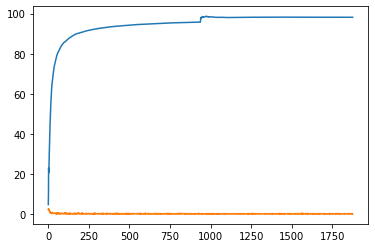

In [36]:
plt.plot(train_acc_history_normalized)
plt.plot(train_loss_history_normalized)

The I will plot the distribution

In [37]:
for name, layer in net.named_modules():
  print(name, layer)

 LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
layer1 Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
layer1.0 Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
layer1.1 ReLU()
layer1.2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [38]:
training_data = enumerate(train_loader_normalized)
batch_idx, (images, labels) = next(training_data)
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


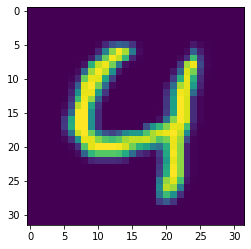

In [39]:
plt.imshow(images[0].squeeze())

In [79]:
return_nodes = {
    "layer1.2": "layer1.2",
    "layer2.1": "layer2.1",
    "fc": "fc",
    "fc1": "fc1",
    "fc2": "fc2"

}
model2 = create_feature_extractor(net, return_nodes=return_nodes)
intermediate_outputs = model2(images[0].reshape((-1, 1,32,32)))

In [80]:
intermediate_outputs['fc1'].shape

torch.Size([1, 84])

In [81]:
intermediate_outputs_layer1_maxpool = intermediate_outputs['layer1.2'][0].reshape(1, 6*14*14)
intermediate_outputs_layer1_maxpool = intermediate_outputs_layer1_maxpool.tolist()[0]
intermediate_outputs_layer2_batchnorm = intermediate_outputs['layer2.1'][0].reshape(1, 16*10*10)
intermediate_outputs_layer2_batchnorm = intermediate_outputs_layer2_batchnorm.tolist()[0]
intermediate_outputs_fc = intermediate_outputs['fc'][0].tolist()
intermediate_outputs_fc1 = intermediate_outputs['fc1'][0].tolist()
intermediate_outputs_fc2 = intermediate_outputs['fc2'][0].tolist()

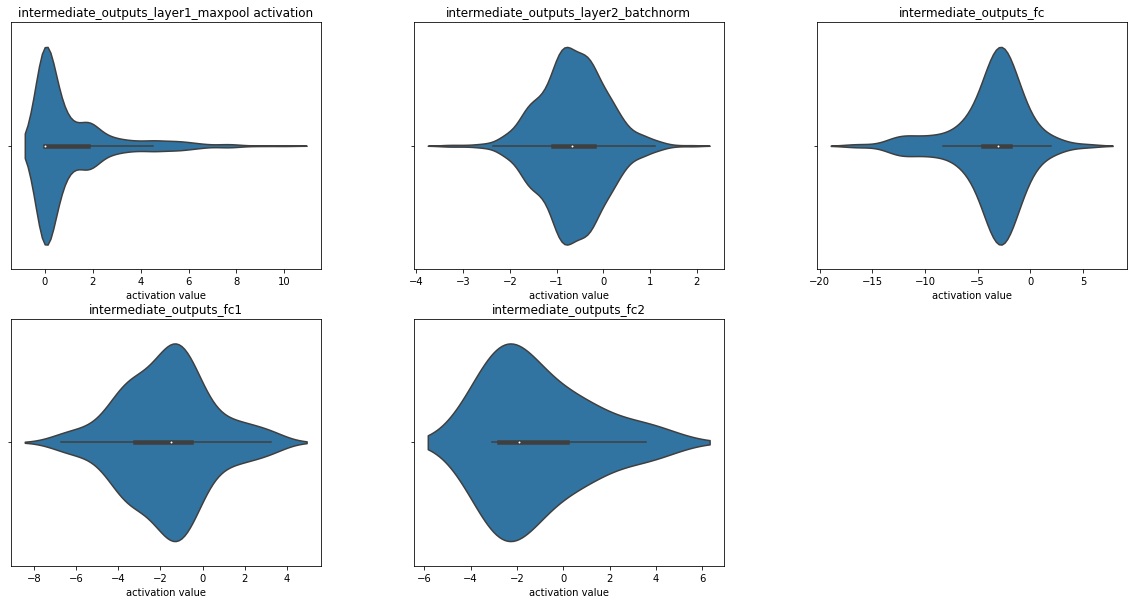

In [82]:
plt.figure(figsize=(20, 10))
plt.subplot(231)
sns.violinplot(x = intermediate_outputs_layer1_maxpool)
plt.title('intermediate_outputs_layer1_maxpool activation')
plt.xlabel('activation value')

plt.subplot(232)
sns.violinplot(x = intermediate_outputs_layer2_batchnorm)
plt.title('intermediate_outputs_layer2_batchnorm')
plt.xlabel('activation value')

plt.subplot(233)
sns.violinplot(x = intermediate_outputs_fc)
plt.title('intermediate_outputs_fc')
plt.xlabel('activation value')

plt.subplot(234)
sns.violinplot(x = intermediate_outputs_fc1)
plt.title('intermediate_outputs_fc1')
plt.xlabel('activation value')

plt.subplot(235)
sns.violinplot(x = intermediate_outputs_fc2)
plt.title('intermediate_outputs_fc2')
plt.xlabel('activation value')

plt.subplots_adjust(wspace = 0.3)

In [100]:
def output_name_and_params(net):
  dict_param = {}
  for name, parameters in net.named_parameters():
    dict_param[name] = parameters
    # print(name)
    # print('name:{},param:{}'.format(name,parameters))
  return dict_param

In [101]:
dict_param = output_name_and_params(net)

In [107]:
layer_2_BN_weight = dict_param['layer2.1.weight'].tolist()
layer_2_BN_bias = dict_param['layer2.1.bias'].tolist()

Text(0.5, 0, 'BN bias')

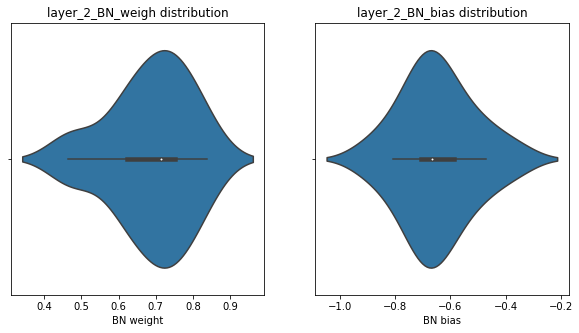

In [109]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.violinplot(x = layer_2_BN_weight)
plt.title('layer_2_BN_weigh distribution')
plt.xlabel('BN weight')

plt.subplot(122)
sns.violinplot(x = layer_2_BN_bias)
plt.title('layer_2_BN_bias distribution')
plt.xlabel('BN bias')

## Problem 3
Next instead of standard normalization use batch normalization for the input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for the input layer improve performance? (4)

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
batch_size = 64
train_dataset_not_normalized = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()]),
                                           download = True)


test_dataset_not_normalized = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor()]),
                                          download=True)


train_loader_not_normalized = torch.utils.data.DataLoader(dataset = train_dataset_not_normalized,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader_not_normalized = torch.utils.data.DataLoader(dataset = test_dataset_not_normalized,
                                           batch_size = batch_size,
                                           shuffle = True)

In [12]:
train_data_size = len(train_dataset_not_normalized)
test_data_size = len(test_dataset_not_normalized)

In [13]:
class LeNet5_BN(nn.Module):
    def __init__(self, num_classes = 10):
        super(LeNet5_BN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [14]:
net2 = LeNet5_BN().to(device)
print(net2)

LeNet5_BN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.01, betas=(0.9,0.999))

In [16]:
train_acc_history_not_normalized = []
train_loss_history_not_normalized = []
epoch = 2
for epo in range(epoch):
  print("{} epoch".format(epo))
  train(net2, train_loader_not_normalized, train_acc_history_not_normalized, train_loss_history_not_normalized)

0 epoch

The batch index: 0, len of train loader: 938, Loss: 2.309, acc: 6.250

The batch index: 1, len of train loader: 938, Loss: 2.360, acc: 10.938

The batch index: 2, len of train loader: 938, Loss: 2.289, acc: 18.229

The batch index: 3, len of train loader: 938, Loss: 2.268, acc: 17.969

The batch index: 4, len of train loader: 938, Loss: 2.155, acc: 22.812

The batch index: 5, len of train loader: 938, Loss: 2.082, acc: 27.865

The batch index: 6, len of train loader: 938, Loss: 2.032, acc: 29.688

The batch index: 7, len of train loader: 938, Loss: 1.951, acc: 32.812

The batch index: 8, len of train loader: 938, Loss: 1.868, acc: 36.806

The batch index: 9, len of train loader: 938, Loss: 1.777, acc: 40.156

The batch index: 10, len of train loader: 938, Loss: 1.699, acc: 42.188

The batch index: 11, len of train loader: 938, Loss: 1.623, acc: 44.531

The batch index: 12, len of train loader: 938, Loss: 1.576, acc: 46.274

The batch index: 13, len of train loader: 938, Loss: 

In [17]:
torch.save(net2, 'lenet_not_normalized_input.pkl')
torch.save(train_loss_history_not_normalized, 'train_loss_history_not_normalized.pkl')
torch.save(train_acc_history_not_normalized, 'train_acc_history_not_normalized.pkl')

In [120]:
training_data = enumerate(train_loader_not_normalized)
batch_idx, (images, labels) = next(training_data)
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


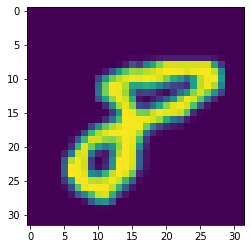

In [121]:
plt.imshow(images[0].squeeze())

In [122]:
for name, layer in net2.named_modules():
  print(name, layer)

 LeNet5_BN(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
layer1 Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, paddi

In [124]:
return_nodes = {
    "layer1.1": "layer1.1",
    "layer2.1": "layer2.1",
    "fc" : "fc",
    "fc1": "fc1",
    "fc2" : "fc2"

}
model3 = create_feature_extractor(net2, return_nodes=return_nodes)
intermediate_outputs = model3(images[0].reshape((-1, 1,32,32)))

In [127]:
intermediate_outputs_layer1_BN = intermediate_outputs['layer1.1'][0].reshape(1, 6*28*28)
intermediate_outputs_layer1_BN = intermediate_outputs_layer1_BN.tolist()[0]
intermediate_outputs_layer2_batchnorm = intermediate_outputs['layer2.1'][0].reshape(1, 16*10*10)
intermediate_outputs_layer2_batchnorm = intermediate_outputs_layer2_batchnorm.tolist()[0]
intermediate_outputs_fc = intermediate_outputs['fc'][0].tolist()
intermediate_outputs_fc1 = intermediate_outputs['fc1'][0].tolist()
intermediate_outputs_fc2 = intermediate_outputs['fc2'][0].tolist()

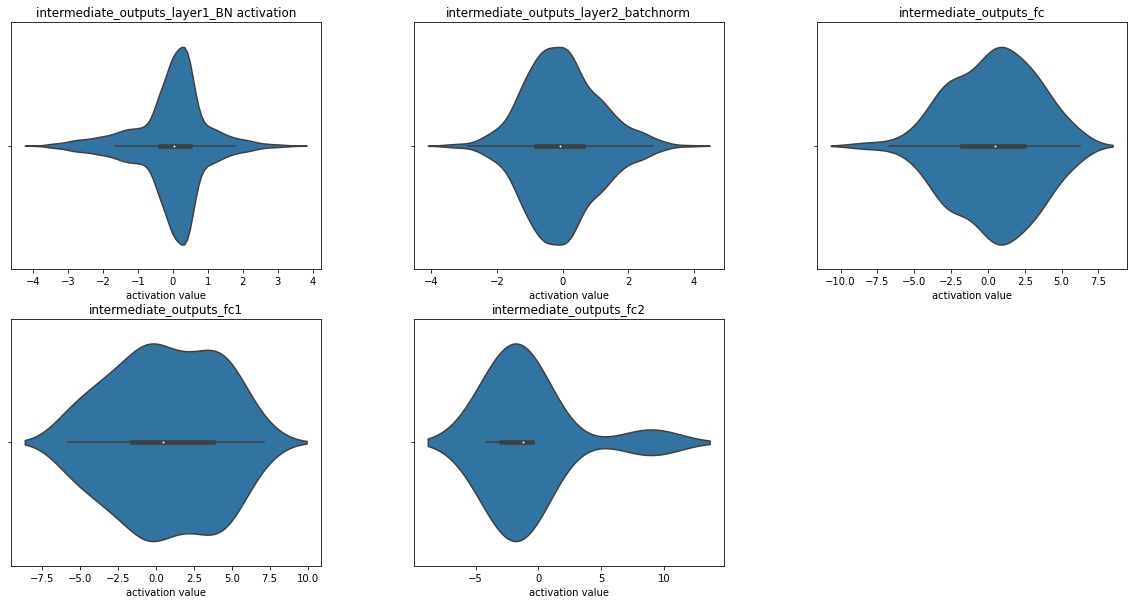

In [128]:
plt.figure(figsize=(20, 10))
plt.subplot(231)
sns.violinplot(x = intermediate_outputs_layer1_BN)
plt.title('intermediate_outputs_layer1_BN activation')
plt.xlabel('activation value')

plt.subplot(232)
sns.violinplot(x = intermediate_outputs_layer2_batchnorm)
plt.title('intermediate_outputs_layer2_batchnorm')
plt.xlabel('activation value')

plt.subplot(233)
sns.violinplot(x = intermediate_outputs_fc)
plt.title('intermediate_outputs_fc')
plt.xlabel('activation value')

plt.subplot(234)
sns.violinplot(x = intermediate_outputs_fc1)
plt.title('intermediate_outputs_fc1')
plt.xlabel('activation value')

plt.subplot(235)
sns.violinplot(x = intermediate_outputs_fc2)
plt.title('intermediate_outputs_fc2')
plt.xlabel('activation value')

plt.subplots_adjust(wspace = 0.3)

In [129]:
dict_param2 = output_name_and_params(net2)

In [130]:
print(dict_param2.keys())

dict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'fc.weight', 'fc.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [132]:
layer_1_BN_weight = dict_param2['layer1.1.weight'].tolist()
layer_1_BN_bias = dict_param2['layer1.1.bias'].tolist()
layer_2_BN_weight = dict_param2['layer2.1.weight'].tolist()
layer_2_BN_bias = dict_param2['layer2.1.bias'].tolist()

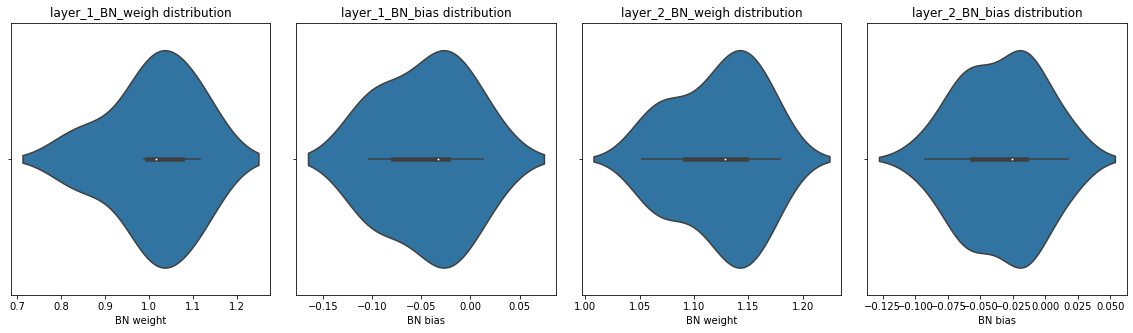

In [138]:
plt.figure(figsize=(20, 5))
plt.subplot(141)
sns.violinplot(x = layer_1_BN_weight)
plt.title('layer_1_BN_weigh distribution')
plt.xlabel('BN weight')

plt.subplot(142)
sns.violinplot(x = layer_1_BN_bias)
plt.title('layer_1_BN_bias distribution')
plt.xlabel('BN bias')

plt.subplot(143)
sns.violinplot(x = layer_2_BN_weight)
plt.title('layer_2_BN_weigh distribution')
plt.xlabel('BN weight')

plt.subplot(144)
sns.violinplot(x = layer_2_BN_bias)
plt.title('layer_2_BN_bias distribution')
plt.xlabel('BN bias')

plt.subplots_adjust(wspace = 0.1)

## Problem 4

Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3. (4)

In [32]:
class LeNet5_Dropout(nn.Module):
    def __init__(self, num_classes = 10):
        super(LeNet5_Dropout, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [33]:
lenet_dropout = LeNet5_Dropout()
lenet_dropout = lenet_dropout.to(device)

In [34]:
print(lenet_dropout)

LeNet5_Dropout(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_dropout.parameters(), lr=0.01, betas=(0.9,0.999))

In [36]:
train_acc_history_dropout = []
train_loss_history_dropout = []
epoch = 2
for epo in range(epoch):
  print("{} epoch".format(epo))
  train(lenet_dropout, train_loader_normalized, train_acc_history_dropout, train_loss_history_dropout)

0 epoch

The batch index: 0, len of train loader: 938, Loss: 2.316, acc: 6.250

The batch index: 1, len of train loader: 938, Loss: 2.328, acc: 6.250

The batch index: 2, len of train loader: 938, Loss: 2.290, acc: 10.417

The batch index: 3, len of train loader: 938, Loss: 2.318, acc: 9.766

The batch index: 4, len of train loader: 938, Loss: 2.321, acc: 9.375

The batch index: 5, len of train loader: 938, Loss: 2.313, acc: 9.635

The batch index: 6, len of train loader: 938, Loss: 2.307, acc: 10.045

The batch index: 7, len of train loader: 938, Loss: 2.300, acc: 10.547

The batch index: 8, len of train loader: 938, Loss: 2.297, acc: 11.632

The batch index: 9, len of train loader: 938, Loss: 2.289, acc: 12.500

The batch index: 10, len of train loader: 938, Loss: 2.291, acc: 12.216

The batch index: 11, len of train loader: 938, Loss: 2.284, acc: 12.891

The batch index: 12, len of train loader: 938, Loss: 2.281, acc: 12.740

The batch index: 13, len of train loader: 938, Loss: 2.27

In [37]:
torch.save(lenet_dropout, 'lenet_dropout.pkl')
torch.save(train_loss_history_dropout, 'train_loss_history_dropout.pkl')
torch.save(train_acc_history_dropout, 'train_acc_history_dropout.pkl')

## Problem 5
Now train the network using both batch, normalization and dropout. How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone? (4)

In [39]:
class LeNet5_both(nn.Module):
    def __init__(self, num_classes = 10):
        super(LeNet5_both, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [40]:
lenet_both = LeNet5_both()
lenet_both = lenet_both.to(device)

In [41]:
print(lenet_dropout)

LeNet5_Dropout(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_both.parameters(), lr=0.01, betas=(0.9,0.999))

In [43]:
train_acc_history_both = []
train_loss_history_both = []
epoch = 2
for epo in range(epoch):
  print("{} epoch".format(epo))
  train(lenet_both, train_loader_normalized, train_acc_history_both, train_loss_history_both)

0 epoch

The batch index: 0, len of train loader: 938, Loss: 2.406, acc: 6.250

The batch index: 1, len of train loader: 938, Loss: 2.419, acc: 7.812

The batch index: 2, len of train loader: 938, Loss: 2.410, acc: 8.854

The batch index: 3, len of train loader: 938, Loss: 2.388, acc: 9.375

The batch index: 4, len of train loader: 938, Loss: 2.378, acc: 8.750

The batch index: 5, len of train loader: 938, Loss: 2.358, acc: 10.417

The batch index: 6, len of train loader: 938, Loss: 2.350, acc: 10.268

The batch index: 7, len of train loader: 938, Loss: 2.341, acc: 10.938

The batch index: 8, len of train loader: 938, Loss: 2.328, acc: 11.979

The batch index: 9, len of train loader: 938, Loss: 2.312, acc: 12.656

The batch index: 10, len of train loader: 938, Loss: 2.314, acc: 12.926

The batch index: 11, len of train loader: 938, Loss: 2.312, acc: 13.151

The batch index: 12, len of train loader: 938, Loss: 2.297, acc: 13.702

The batch index: 13, len of train loader: 938, Loss: 2.29

In [44]:
torch.save(lenet_both, 'lenet_both.pkl')
torch.save(train_loss_history_both, 'train_loss_history_both.pkl')
torch.save(train_acc_history_both, 'train_acc_history_both.pkl')

compare the train loss, train acc and test acc of all models

In [19]:
acc_norm = torch.load("/content/train_acc_history_normalized.pkl")
acc_not_norm = torch.load("/content/train_acc_history_not_normalized.pkl")
acc_dropout = torch.load("/content/train_acc_history_dropout.pkl")
acc_both = torch.load("/content/train_acc_history_both.pkl")

In [24]:
loss_norm = torch.load("/content/train_loss_history_normalized.pkl")
loss_not_norm = torch.load("/content/train_loss_history_not_normalized.pkl")
loss_dropout = torch.load("/content/train_loss_history_dropout.pkl")
loss_both = torch.load("/content/train_loss_history_both.pkl")

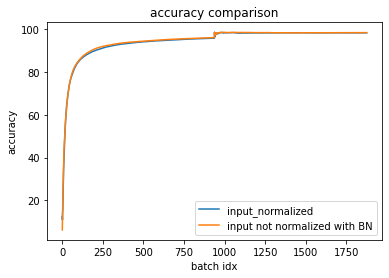

In [63]:
plt.plot(acc_norm, label = "input_normalized")
plt.plot(acc_not_norm, label = "input not normalized with BN")
# plt.plot(acc_dropout, label = "dropout")
# plt.plot(acc_both, label = "BN and dropout")
plt.xlabel("batch idx")
plt.ylabel("accuracy")
plt.title("accuracy comparison")
plt.legend()
plt.show()

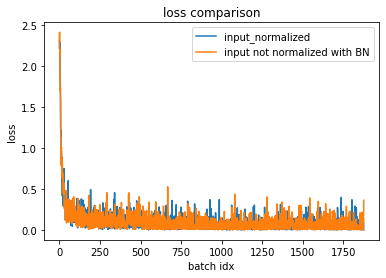

In [64]:
plt.plot(loss_norm, label = "input_normalized")
plt.plot(loss_not_norm, label = "input not normalized with BN")
# plt.plot(loss_dropout, label = "dropout")
# plt.plot(loss_both, label = "BN and dropout")
plt.xlabel("batch idx")
plt.ylabel("loss")
plt.title("loss comparison")
plt.legend()
plt.show()

test accuracy

In [45]:
model1 = torch.load("/content/lenet_normalized_input.pkl")
model2 = torch.load("/content/lenet_not_normalized_input.pkl")
model3 = torch.load("/content/lenet_dropout.pkl")
model4 = torch.load("/content/lenet_both.pkl")
models = [model1, model2, model3, model4]

In [48]:
test_acc = []
for model in models:
  acc = test(model, test_loader_normalized)
  test_acc.append(acc)

tes acc: 98.53
tes acc: 92.44
tes acc: 95.07
tes acc: 96.91


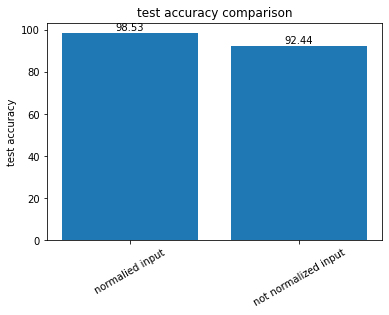

In [67]:
bars = ['normalied input', 'not normalized input', 'dropout', 'BN + dropout']
# y_pos = np.arange(len(bars))
plt.bar(bars[0:2], test_acc[0:2])
plt.xticks(bars[0:2], bars[0:2], rotation = 30)
plt.ylabel('test accuracy')
plt.title("test accuracy comparison")
for a, b in zip(bars[0:2], test_acc[0:2]):
  plt.text(a, b + 0.05, '%.2f' % b, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()